### Importing Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score , classification_report
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import scikitplot as skplt

global_start = datetime.datetime.now()

### Loading Data

In [31]:
with open('finaldata.pkl', 'rb') as f: 
    final = pickle.load(f)



In [32]:
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


### Random Sapmpling the Data

In [33]:
fsubset = final.sample(n = 125000,random_state=42).reset_index(drop = True)

In [34]:
# Deleting from RAM
del final 

In [35]:
fsubset = fsubset.sort_values(by = ['Time'])

In [36]:
X = np.array(fsubset['CleanedText'])
print(X.shape)
y = np.array(fsubset['Score'])
print(y.shape)


(125000,)
(125000,)


### Train-Test Data splitting

In [37]:
X_train_train, X_test_train, y_train, y_test =train_test_split(X, y,test_size = 0.3,random_state = 42, shuffle = False)


In [38]:
print(X_train_train.shape)
print(X_test_train.shape)
print(y_train.shape)
print(y_test.shape)


(87500,)
(37500,)
(87500,)
(37500,)


### Cross Validation using Stratified K-fold

In [39]:
# The following function performs hyperparameter tuning using cross-validation.
# We will find the optimum value of alpha by finding the hight weighted f-1 score
def nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=True):
    
    start = datetime.datetime.now()
    
    # values of alphas to iterate over.
    alpha_values = np.linspace(0.01, 0.1, 10)
    
    # creating a stratified Kfold object
    skf = StratifiedKFold(n_splits=10)
    
    # To store f1-scores corresponding to each alpha.
    cv_f1_scores = {}
        
    # perform 10-fold cross validation
    if bernoulli:
        for alpha in alpha_values:
            clf = BernoulliNB(alpha=alpha, fit_prior=calculate_class_priors)
            f1_score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='f1_weighted').mean()
            cv_f1_scores[alpha] = f1_score
           
    else:
        for alpha in alpha_values:
            clf = MultinomialNB(alpha=alpha, fit_prior=calculate_class_priors)
            f1_score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='f1_weighted').mean()
            cv_f1_scores[alpha] = f1_score
    
       
    # Find the optimal alpha
    optimal_alpha = max(cv_f1_scores , key = cv_f1_scores.get)
    
    # Plot alpha v/s f1-score
    plt.figure(figsize=(15,10))
    plt.plot(cv_f1_scores.keys(), cv_f1_scores.values())
    plt.xlabel('Alpha')
    plt.ylabel('weighted f1-score')
    plt.title('f1-score v/s alpha')
    plt.show()

    print('The optimum value of alpha based on cross-validation is : {}'.format(optimal_alpha))
    print('Time taken : {}'.format(datetime.datetime.now() - start))
    
    return optimal_alpha

### Prediction report using various hyperparameters

In [41]:
# The following fucntion generates classification reports based on Test data predictions
def evaluate_test_predictions(y_test, y_pred):
    print('\n########## CLASSIFICATION REPORTS ON TEST DATA##########')
    print('accuracy on test data : {}'.format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    

#### Print top words of each class

In [42]:
def top_words(clf, feature):
    neg_class_prob_sorted = clf.feature_log_prob_[0, :-1].argsort()[::-1]
    pos_class_prob_sorted = clf.feature_log_prob_[1, :-1].argsort()[::-1]
    print('negative class words :',np.take(count_vec.get_feature_names(), neg_class_prob_sorted[:10]))
    print('positive class words :',np.take(count_vec.get_feature_names(), pos_class_prob_sorted[:10]))

### Bag of Words with binomial distribution and using class priority probabilities

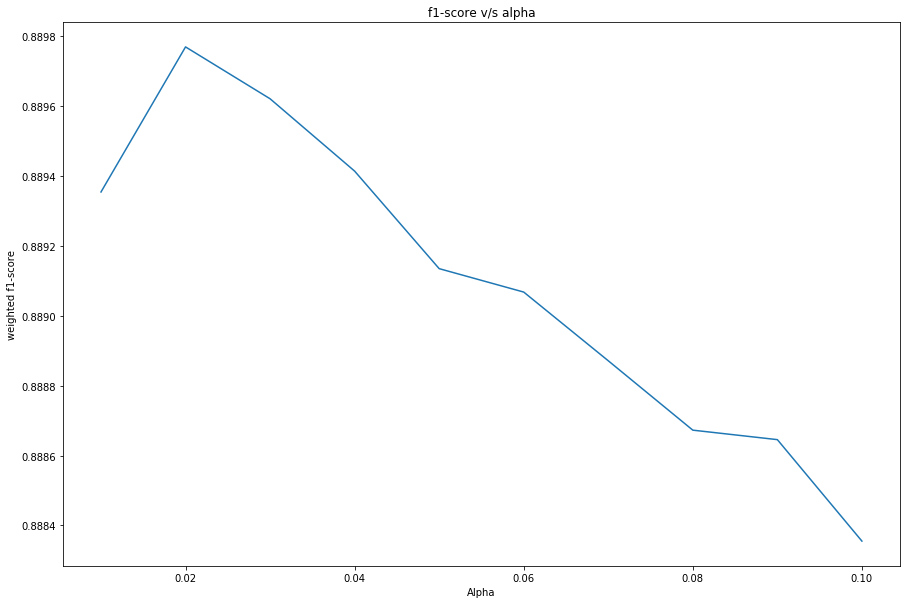

The optimum value of alpha based on cross-validation is : 0.020000000000000004
Time taken : 0:00:19.643407

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8843733333333333
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      6576
           1       0.92      0.94      0.93     30924

   micro avg       0.88      0.88      0.88     37500
   macro avg       0.80      0.79      0.80     37500
weighted avg       0.88      0.88      0.88     37500

negative class words : ['tast' 'like' 'product' 'one' 'would' 'tri' 'flavor' 'good' 'buy' 'get']
positive class words : ['like' 'tast' 'love' 'good' 'great' 'flavor' 'one' 'use' 'tri' 'product']


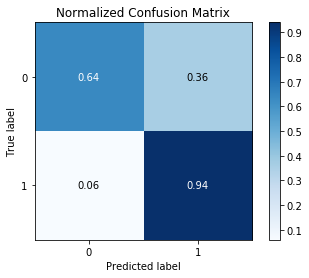

In [43]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer(binary=True)
X_train = count_vec.fit_transform(X_train_train)
X_test = count_vec.transform(X_test_train)

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=True, calculate_class_priors=True)

# Predictions on test data
clf = BernoulliNB(alpha=optimal_alpha)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)
top_words(clf, count_vec)

### Bag of Words with multinomial distribution and using uniform prior probabilities

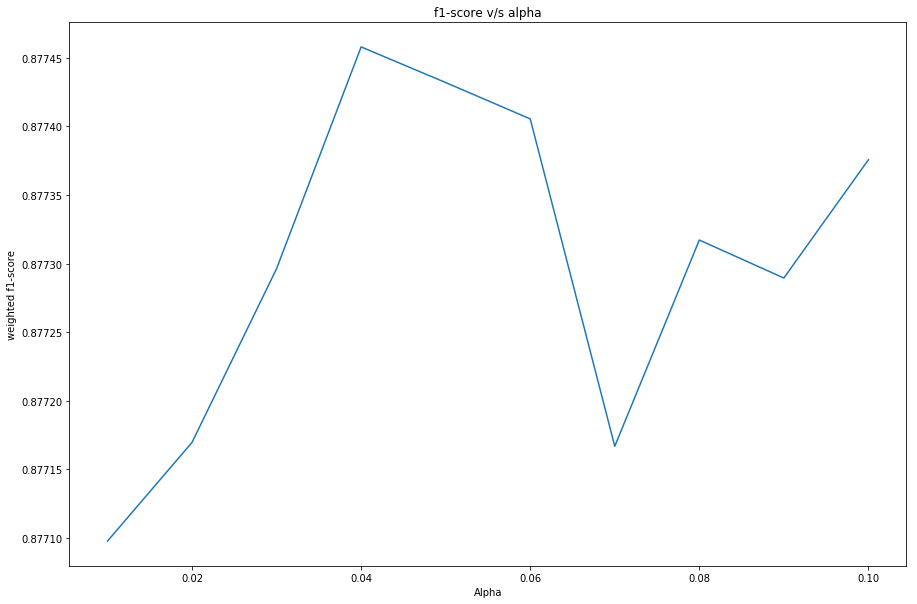

The optimum value of alpha based on cross-validation is : 0.04000000000000001
Time taken : 0:00:10.813183

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.89384
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      6576
           1       0.93      0.94      0.94     30924

   micro avg       0.89      0.89      0.89     37500
   macro avg       0.82      0.81      0.81     37500
weighted avg       0.89      0.89      0.89     37500

negative class words : ['tast' 'like' 'product' 'one' 'would' 'tri' 'flavor' 'good' 'buy' 'get']
positive class words : ['like' 'tast' 'love' 'good' 'great' 'flavor' 'one' 'use' 'tri' 'product']


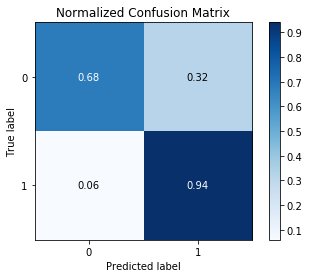

In [44]:
# ************** Creating Bag Of Words ***************************
count_vec = CountVectorizer(binary=True)
X_train = count_vec.fit_transform(X_train_train)
X_test = count_vec.transform(X_test_train)

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=False)

# Predictions on test data
clf = MultinomialNB(alpha=optimal_alpha)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)
top_words(clf,count_vec)

### Tf-idf with binomial distribution and using class prior probabilities

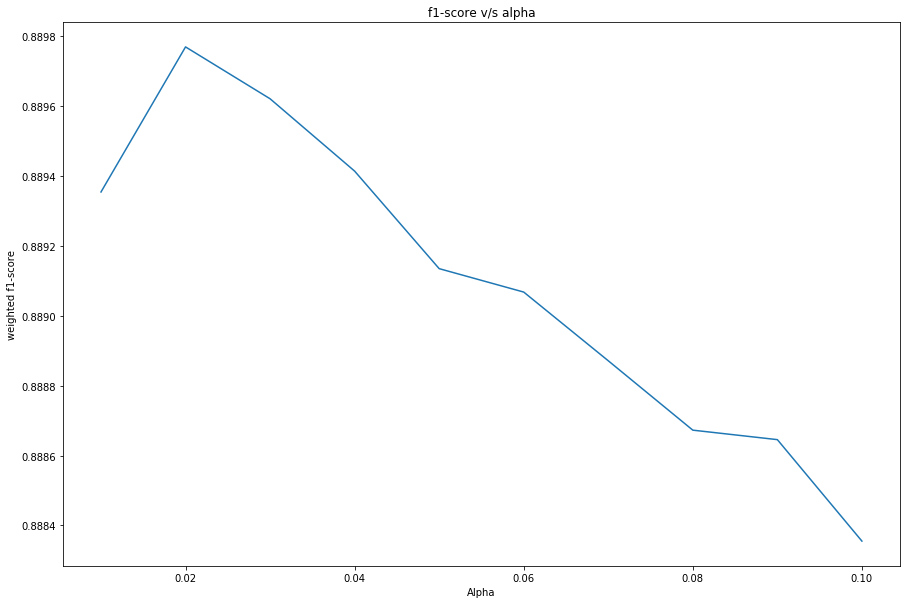

The optimum value of alpha based on cross-validation is : 0.020000000000000004
Time taken : 0:00:18.819423

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8843733333333333
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      6576
           1       0.92      0.94      0.93     30924

   micro avg       0.88      0.88      0.88     37500
   macro avg       0.80      0.79      0.80     37500
weighted avg       0.88      0.88      0.88     37500

negative class words : ['tast' 'like' 'product' 'one' 'would' 'tri' 'flavor' 'good' 'buy' 'get']
positive class words : ['like' 'tast' 'love' 'good' 'great' 'flavor' 'one' 'use' 'tri' 'product']


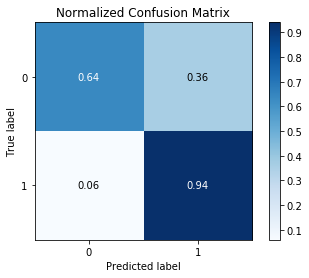

In [45]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_train)
X_test = tf_idf_vect.transform(X_test_train)

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=True, calculate_class_priors=True)

# Predictions on test data
clf = BernoulliNB(alpha=optimal_alpha)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)
top_words(clf,tf_idf_vect)

###  Tf-idf with multinomial distribution and using class prior probabilities

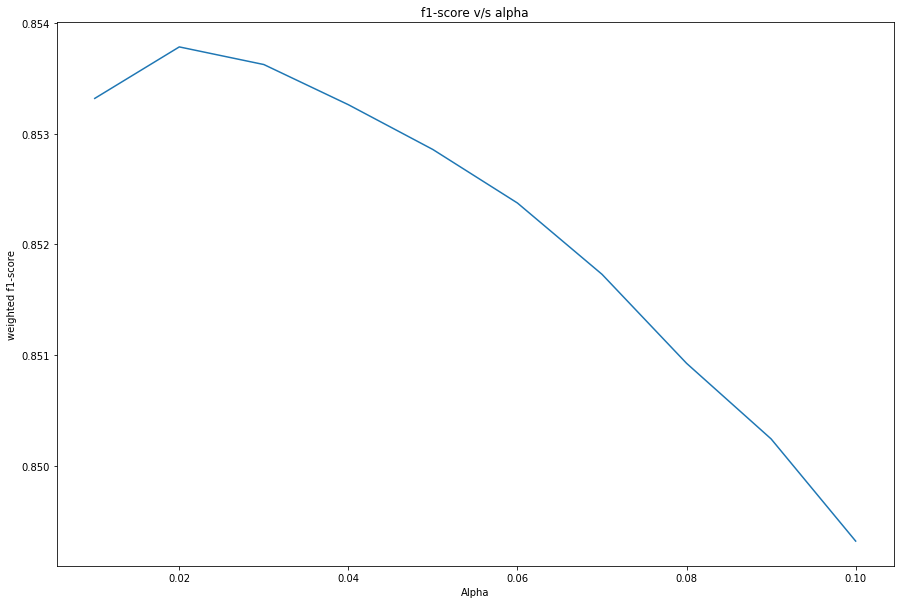

The optimum value of alpha based on cross-validation is : 0.020000000000000004
Time taken : 0:00:14.128650

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.86168
              precision    recall  f1-score   support

           0       0.87      0.25      0.39      6576
           1       0.86      0.99      0.92     30924

   micro avg       0.86      0.86      0.86     37500
   macro avg       0.87      0.62      0.65     37500
weighted avg       0.86      0.86      0.83     37500

negative class words : ['tast' 'like' 'product' 'flavor' 'would' 'one' 'coffe' 'tri' 'buy'
 'order']
positive class words : ['great' 'love' 'tast' 'good' 'like' 'tea' 'flavor' 'coffe' 'product'
 'use']


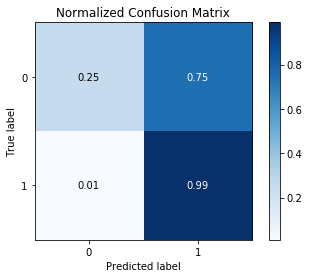

In [46]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train_train)
X_test = tf_idf_vect.transform(X_test_train)

# cross validation
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=True)

# Predictions on test data
clf = MultinomialNB(alpha=optimal_alpha)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)
top_words(clf,tf_idf_vect)

#### Adding a column 'Text Length': Number of words in the text review

In [47]:
fsubset['Text_length'] = fsubset['Text'].apply(lambda x : len(x.split()))

In [48]:
fsubset.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Text_length
78027,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,74
17281,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,78
68981,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...,68
19899,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...,223
11596,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,get crazi realli imposs today find french vhs ...,27


In [52]:
X_test = fsubset.iloc[:,[11,12]]
y_test = fsubset['Score']

#### Taking Number of words into consideration for building the model

In [53]:
X_train_train, X_test_train, y_train, y_test = train_test_split(X_test, y_test, test_size=0.30, shuffle=False)

# Sanity check
print('Shape of X_train_train : {}'.format(X_train_train.shape))
print('Shape of y_train : {}'.format(y_train.shape))
print()
print('Shape of X_text_train : {}'.format(X_test_train.shape))
print('Shape of y_test : {}'.format(y_test.shape))

Shape of X_train_train : (87500, 2)
Shape of y_train : (87500,)

Shape of X_text_train : (37500, 2)
Shape of y_test : (37500,)


In [54]:
count_vec = CountVectorizer()
X_train_bow = count_vec.fit_transform(X_train_train['CleanedText'])
print('\nType of X_train_bow : {}'.format(type(X_train_bow)))
print('Shape of X_train_bow : {}'.format(X_train_bow.get_shape()))
print('Number of unique words : {}'.format(X_train_bow.get_shape()[1]))
X_train = hstack((X_train_bow,X_train_train['Text_length'][:, None]))
print('\nShape of X_train : {}'.format(X_train.get_shape()))


Type of X_train_bow : <class 'scipy.sparse.csr.csr_matrix'>
Shape of X_train_bow : (87500, 35668)
Number of unique words : 35668

Shape of X_train : (87500, 35669)


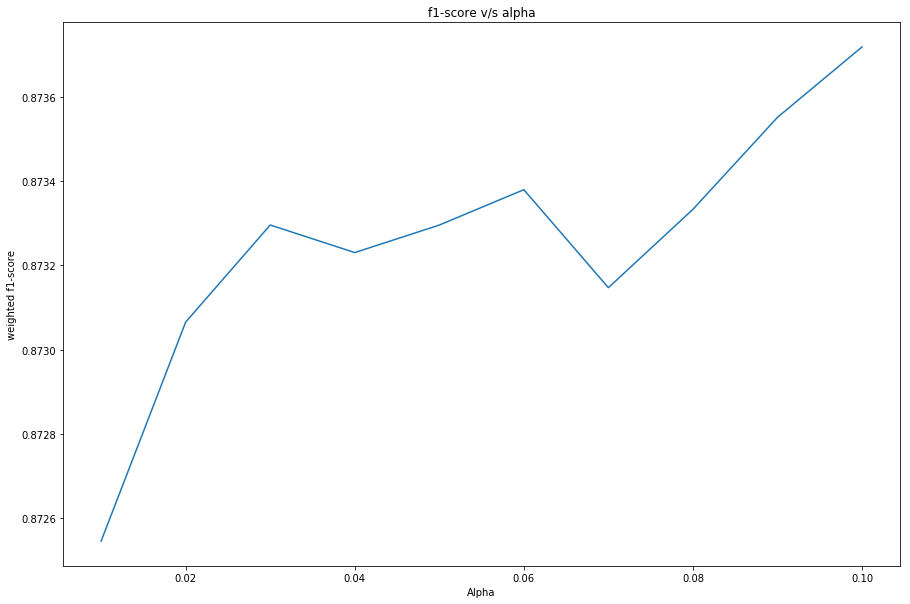

The optimum value of alpha based on cross-validation is : 0.1
Time taken : 0:00:16.586881


In [55]:
optimal_alpha = nb_cv(X_train, y_train, bernoulli=False, calculate_class_priors=False)

Shape of X_test : (37500, 35669)

########## CLASSIFICATION REPORTS ON TEST DATA##########
accuracy on test data : 0.8627733333333333
              precision    recall  f1-score   support

           0       0.58      0.81      0.67      6576
           1       0.96      0.87      0.91     30924

   micro avg       0.86      0.86      0.86     37500
   macro avg       0.77      0.84      0.79     37500
weighted avg       0.89      0.86      0.87     37500

negative class words : ['tast' 'like' 'product' 'one' 'flavor' 'would' 'tri' 'good' 'use' 'coffe']
positive class words : ['like' 'tast' 'good' 'flavor' 'love' 'great' 'use' 'one' 'product' 'tea']


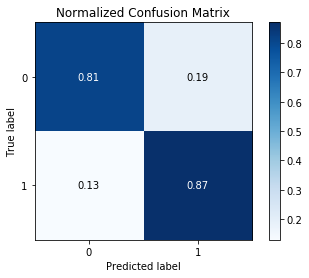

In [56]:
X_test_bow = count_vec.transform(X_text_train['CleanedText'])
X_test = hstack((X_test_bow,X_text_train['Text_length'][:, None]))
print('Shape of X_test : {}'.format(X_test.get_shape()))

# Make Predictions on Test data
clf = MultinomialNB(alpha=optimal_alpha, fit_prior=False)
y_pred = clf.fit(X_train, y_train).predict(X_test)
evaluate_test_predictions(y_test, y_pred)

# Print feature importance
neg_class_prob_sorted = clf.feature_log_prob_[0, :-1].argsort()[::-1]
pos_class_prob_sorted = clf.feature_log_prob_[1, :-1].argsort()[::-1]
print('negative class words :',np.take(count_vec.get_feature_names(), neg_class_prob_sorted[:10]))
print('positive class words :',np.take(count_vec.get_feature_names(), pos_class_prob_sorted[:10]))